In [1]:
import joblib 
import pandas as pd
import numpy as np
from itertools import zip_longest
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def plot_sensor_byid(df, start, end):
    '''
    描述：
        绘制Current_1，Vibration_1的图像
    '''
    plt.figure(figsize=(16,6))
    f = (df['id']>=start)&(df['id']<end)

    plt.subplot(1,2,1)
    df.loc[f,'Current_1'].plot()
    plt.title('Current_1')

    plt.subplot(1,2,2)
    df.loc[f,'Vibration_1'].plot()
    plt.title('Vibration_1')

In [13]:

def check_for_nans_in_columns(df, columns=None):
    '''
    描述：
        统计一个DataFrame的nans分布情况
    '''
    if columns is None:
        columns = df.columns

    if pd.isnull(df.loc[:, columns]).any().any():
        if not isinstance(columns, list):
            columns = list(columns)
        result = df.loc[:, columns].columns[pd.isnull(df.loc[:, columns]).sum() > 0].tolist()
    else:
        result = []
    return result

def check_for_infs_in_columns(df, columns=None):
    '''
    描述：
        统计一个DataFrame的inf分布情况
    '''
    if columns is None:
        columns = df.columns

    if np.isinf(df.loc[:, columns]).any().any():
        if not isinstance(columns, list):
            columns = list(columns)
        result = df.loc[:, columns].columns[np.isinf(df.loc[:, columns]).sum() > 0].tolist()
    else:
        result = []
    return result

def gen_boxplot_bound(ser):
    '''
    描述：
        输出箱线图的异常值边界,输出上下边界以及fillna()之后的结果
    '''
    ser = ser.fillna(method='pad')
    tmp = ser.values.ravel()
    q1 = np.percentile(tmp, 0.1)
    q3 = np.percentile(tmp, 99.9)
    iqr = q3 -q1
    up_bound = q3 + 10*iqr
    down_bound = q1 - 10*iqr
    return up_bound, down_bound, ser
    
def check_for_outliers_in_columns(df, columns=None):
    '''
    描述：
        统计一个DataFrame的、outliers分布情况
    '''
    if columns is None:
        columns = df.columns
    
    result = []
    
    for col in columns:
        up_bound, down_bound, ser = gen_boxplot_bound(df[col])
        if ((ser<down_bound)|(ser>up_bound)).any():
            result.append(col)
    return result

def check_parallel(train_no, csv_nos, opt_func):
    '''
    描述：
        并行统计多个sensor文件的nans分布情况
    '''
    input_dir = '../2.1preprocess_train_data/sensors/'
    mydict = {}
    def func(train_no, idx):
        sensor = joblib.load(input_dir+'0%d/%d.lz4'%(train_no, idx))
        return opt_func(sensor)
        
    result_list = Parallel(n_jobs=48, verbose=1)(delayed(func)(train_no, idx) for idx in range(1, csv_nos+1))
    return {key:val for key,val in zip_longest(range(1, csv_nos+1), result_list)}

### nans

In [14]:
nans_result_01 = check_parallel(1, 48, check_for_nans_in_columns)
nans_result_02 = check_parallel(2, 48, check_for_nans_in_columns)
nans_result_03 = check_parallel(3, 37, check_for_nans_in_columns)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:   28.8s remaining: 11.0min
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:   45.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:   34.6s remaining: 13.3min
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:   44.6s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  18 out of  37 | elapsed:   33.6s remaining:   35.4s
[Parallel(n_jobs=48)]: Done  37 out of  37 | elapsed:   33.8s finished


In [18]:
if not os.path.exists('./train_clean_condition'):
    os.mkdir('./train_clean_condition')
joblib.dump((nans_result_01, nans_result_02, nans_result_03), './train_clean_condition/nans_condition_tuple')

['./train_clean_condition/nans_condition_tuple']

### infs

In [19]:
inf_result_01 = check_parallel(1, 48, check_for_infs_in_columns)
inf_result_02 = check_parallel(2, 48, check_for_infs_in_columns)
inf_result_03 = check_parallel(3, 37, check_for_infs_in_columns)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:    0.9s remaining:   20.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:    0.8s remaining:   19.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  18 out of  37 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  37 out of  37 | elapsed:    1.0s finished


In [20]:
if not os.path.exists('./train_clean_condition'):
    os.mkdir('./train_clean_condition')
joblib.dump((inf_result_01, inf_result_02, inf_result_03), './train_clean_condition/infs_condition_tuple')

['./train_clean_condition/infs_condition_tuple']

### naive_outliers(去除绝对值接近极限的异常值)

In [21]:
outlier_result_01 = check_parallel(1, 48, check_for_outliers_in_columns)
outlier_result_02 = check_parallel(2, 48, check_for_outliers_in_columns)
outlier_result_03 = check_parallel(3, 37, check_for_outliers_in_columns)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:    0.9s remaining:   21.8s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.6s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 out of  48 | elapsed:    0.8s remaining:   17.7s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    1.7s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  18 out of  37 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=48)]: Done  37 out of  37 | elapsed:    1.2s finished


In [22]:
joblib.dump((outlier_result_01, outlier_result_02, outlier_result_03), './train_clean_condition/outliers_condition_tuple')

['./train_clean_condition/outliers_condition_tuple']

In [25]:
# 查看那一台设备的第几块文件存在异常值
# outlier_result_01

### 检查naive_outliers的结果

In [26]:
# sensor_01_2
sensor_01_2 = joblib.load('../2.1preprocess_train_data/sensors/01/2.lz4')

up_bound, down_bound, ser = gen_boxplot_bound(sensor_01_2['Vibration_3'])
up_bound, down_bound

(182.96714278552747, -182.61940789133843)

In [27]:
sensor_01_2['Vibration_2'].describe()

count     1.548798e+06
mean               inf
std                inf
min     -1.731969e+308
25%      -9.281607e-01
50%       5.127751e-03
75%       9.286588e-01
max      1.614959e+308
Name: Vibration_2, dtype: float64

# 1.sensor_01

## sensor_01_1

In [35]:
sensor_01_1 = joblib.load('../2.1preprocess_train_data/sensors_id_sort/01/1.lz4')

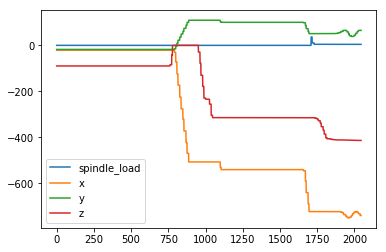

In [32]:
plc_01 = joblib.load('../2.1preprocess_train_data/train_plc_RULR/train_01_plc.lz4')
plc_01_1 = plc_01[plc_01['csv_no']==1]
plc_01_1[['spindle_load','x','y','z']].plot()

Text(0.5, 1.0, 'Vibration_1')

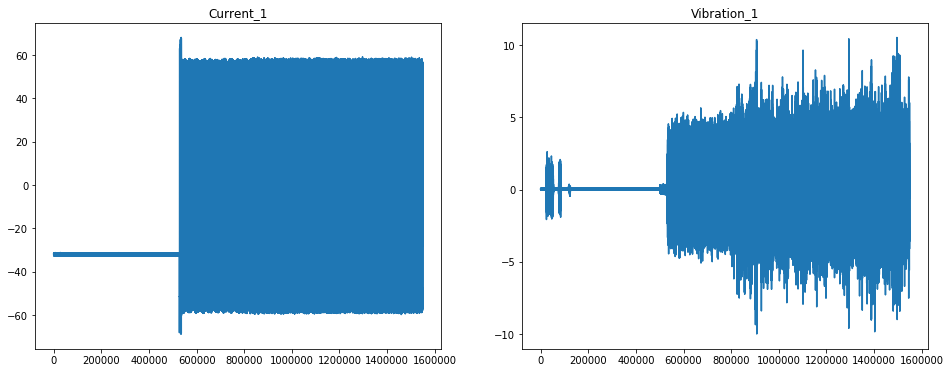

In [36]:
# 查看Current_1，Vibration_1
plt.figure(figsize=(16,6))
f = (sensor_01_1['id']>=0)&(sensor_01_1['id']<2500)

plt.subplot(1,2,1)
sensor_01_1.loc[f,'Current_1'].plot()
plt.title('Current_1')

plt.subplot(1,2,2)
sensor_01_1.loc[f,'Vibration_1'].plot()
plt.title('Vibration_1')

Text(0.5,1,'Vibration_1')

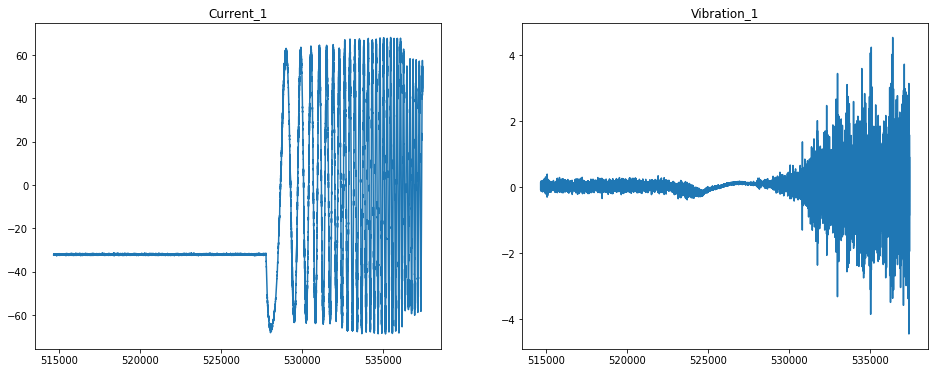

In [146]:
# 模式发生了改变
plt.figure(figsize=(16,6))
f = (sensor_01_1['id']>=680)&(sensor_01_1['id']<710)

plt.subplot(1,2,1)
sensor_01_1.loc[f,'Current_1'].plot()
plt.title('Current_1')

plt.subplot(1,2,2)
sensor_01_1.loc[f,'Vibration_1'].plot()
plt.title('Vibration_1')

Text(0.5,1,'Vibration_1')

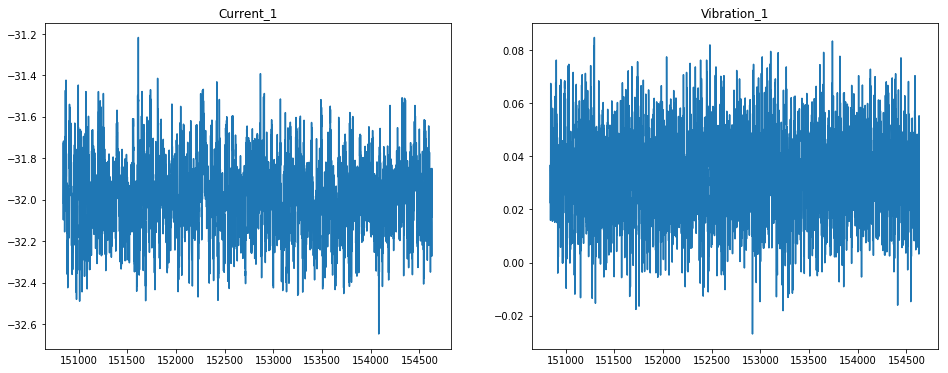

In [148]:
# 模式1
plt.figure(figsize=(16,6))
f = (sensor_01_1['id']>=200)&(sensor_01_1['id']<205)

plt.subplot(1,2,1)
sensor_01_1.loc[f,'Current_1'].plot()
plt.title('Current_1')

plt.subplot(1,2,2)
sensor_01_1.loc[f,'Vibration_1'].plot()
plt.title('Vibration_1')

Text(0.5,1,'Vibration_1')

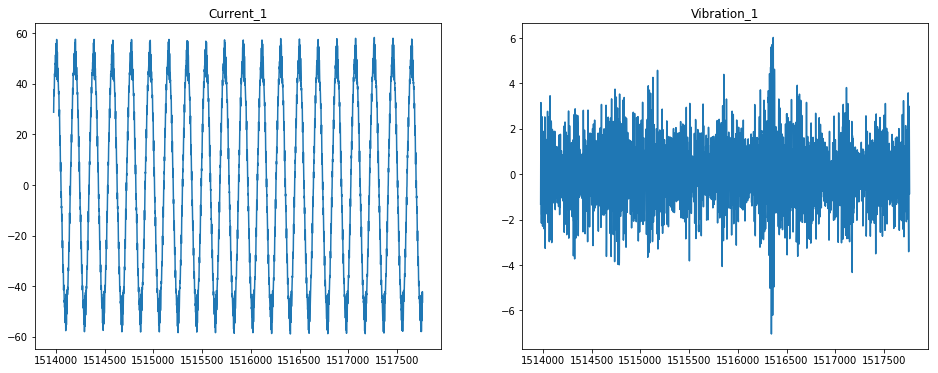

In [155]:
# 模式2——正弦波
plt.figure(figsize=(16,6))
f = (sensor_01_1['id']>=2000)&(sensor_01_1['id']<2005)

plt.subplot(1,2,1)
sensor_01_1.loc[f,'Current_1'].plot()
plt.title('Current_1')

plt.subplot(1,2,2)
sensor_01_1.loc[f,'Vibration_1'].plot()
plt.title('Vibration_1')

### sensor_01_48

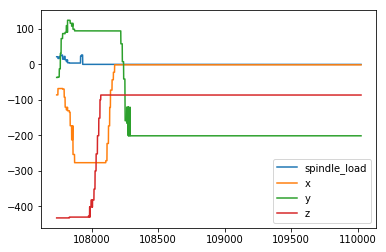

In [43]:
sensor_01_48 = joblib.load('../2.1preprocess_train_data/sensors/01/24.lz4')
plc_01 = joblib.load('../../刀具剩余寿命预测_新数据/2.1preprocess_train_data/train_plc/train_01_plc.lz4')
plc_01_48 = plc_01[plc_01['csv_no']==48]
plc_01_48[['spindle_load','x','y','z']].plot()

In [ ]:
plc_01_48 = plc[plc['csv_no']==48]
plc_01_48[['spindle_load','x','y','z']].plot()

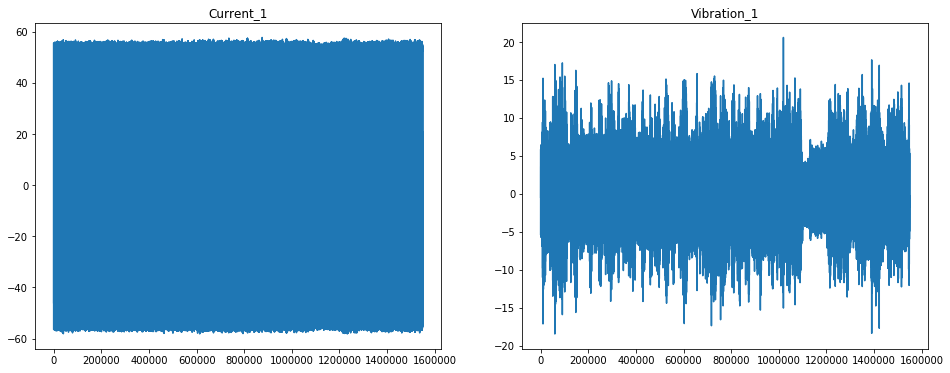

In [173]:
# 查看Current_1，Vibration_1
plot_sensor_byid(sensor_01_48, 0, 2500)

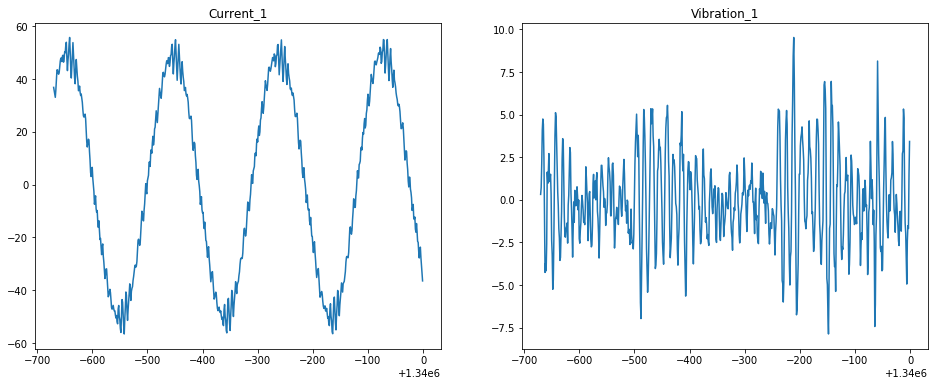

In [21]:
# 查看局部
plot_sensor_byid(sensor_01_48, 2000, 2001)

### sensor_01_*

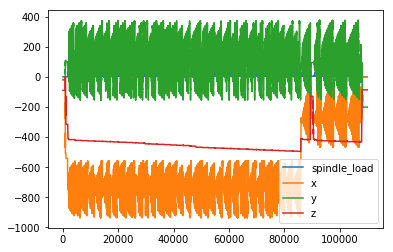

In [96]:
plc_01.loc[plc_01['csv_no'] <= 48,['spindle_load','x','y','z']].plot()

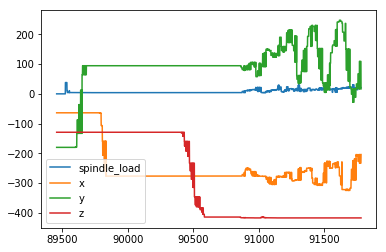

In [100]:
plc_01.loc[plc_01['csv_no'] == 40,['spindle_load','x','y','z']].plot()

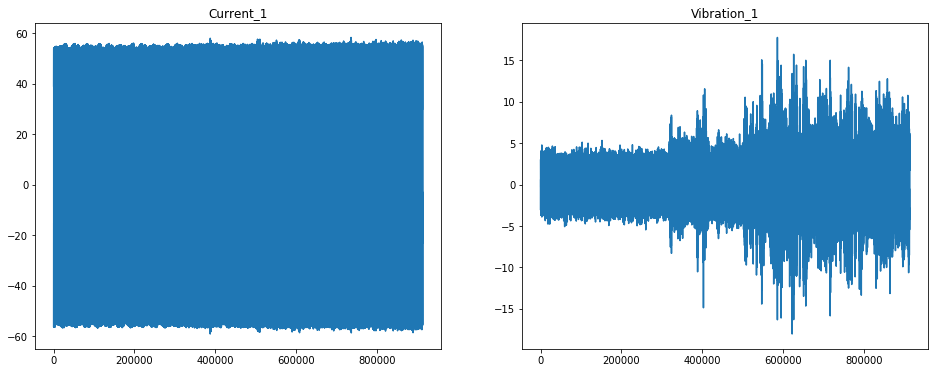

In [40]:
sensor_01_40 = joblib.load('../2.1preprocess_train_data/sensors_id_sort/01/40.lz4')
plot_sensor_byid(sensor_01_40,0,2000)

# 2.sensor_02

### sensor_02_1

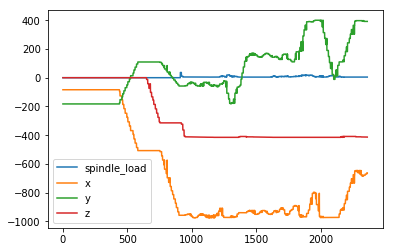

In [35]:
sensor_02_1 = joblib.load('../2.1preprocess_train_data/sensors/02/1.lz4')
plc_02 = joblib.load('../../刀具剩余寿命预测_新数据/2.1preprocess_train_data/train_plc/train_02_plc.lz4')
plc_02_1 = plc_02[plc_02['csv_no']==1]
plc_02_1[['spindle_load','x','y','z']].plot()

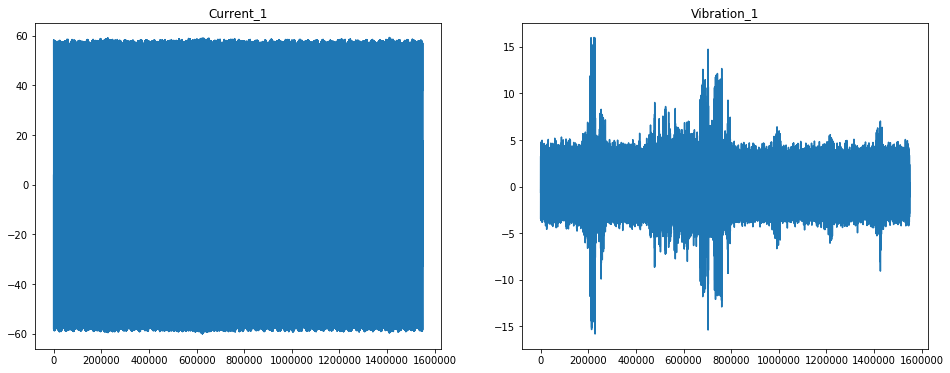

In [8]:
# 查看Current_1，Vibration_1
plot_sensor_byid(sensor_02_1, 0, 2500)

### sensor_02_*

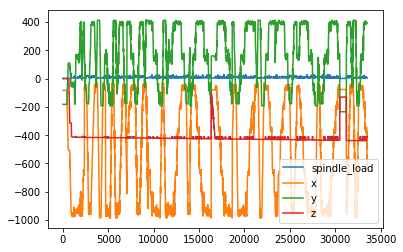

In [107]:
plc_02.loc[plc_02['csv_no']<=15, ['spindle_load','x','y','z']].plot()

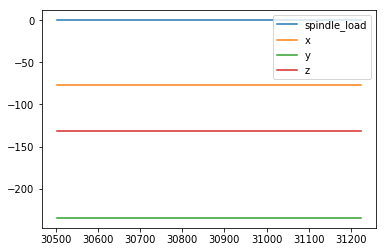

In [105]:
plc_02.loc[plc_02['csv_no']==14, ['spindle_load','x','y','z']].plot()

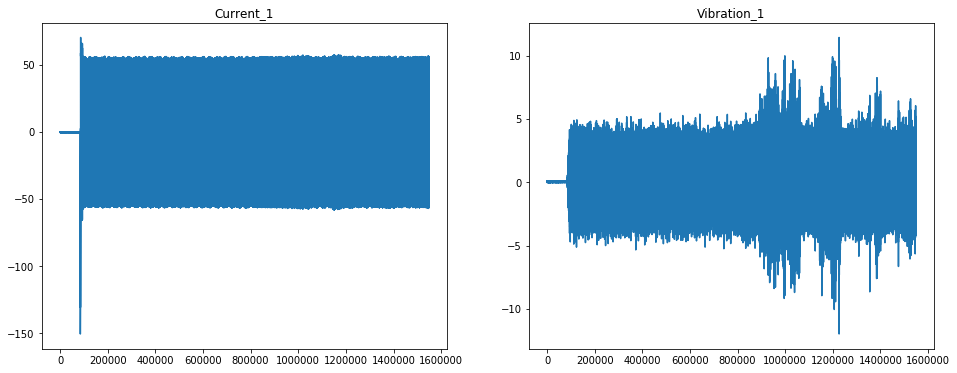

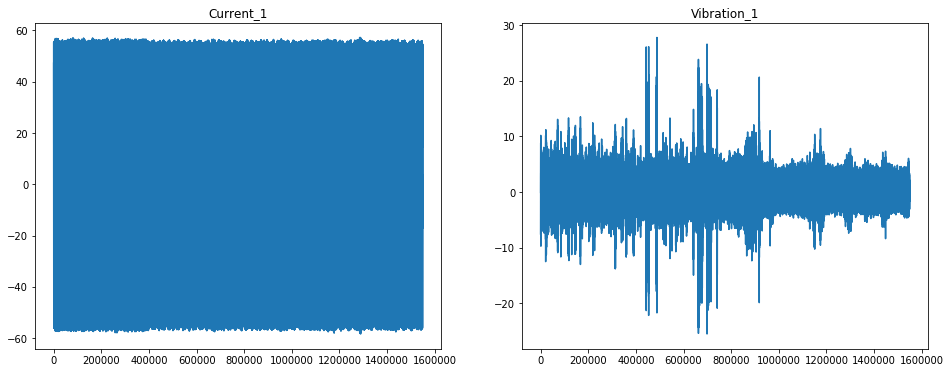

In [109]:
sensor_02_14 = joblib.load('../2.1preprocess_train_data/sensors/02/14.lz4')
sensor_02_15 = joblib.load('../2.1preprocess_train_data/sensors/02/15.lz4')
plot_sensor_byid(sensor_02_14, 0, 2500)

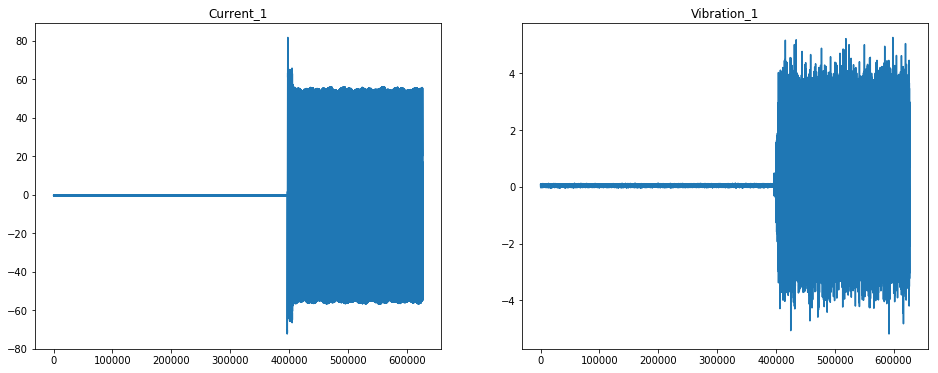

In [156]:
sensor_02_42 = joblib.load('../2.1preprocess_train_data/sensors/02/42.lz4')
plot_sensor_byid(sensor_02_42, 0, 2500)

### sensor_03_1

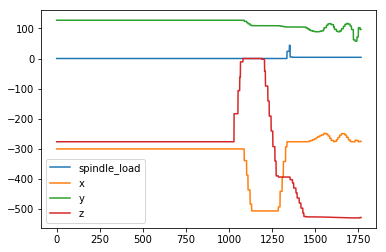

In [112]:
sensor_03_1 = joblib.load('../2.1preprocess_train_data/sensors/03/1.lz4')
plc_03 = joblib.load('../../刀具剩余寿命预测_新数据/2.1preprocess_train_data/train_plc/train_03_plc.lz4')
plc_03 = correct_csv_no_03_plc(plc_03)
plc_03.loc[plc_03['csv_no']==1,['spindle_load','x','y','z']].plot()

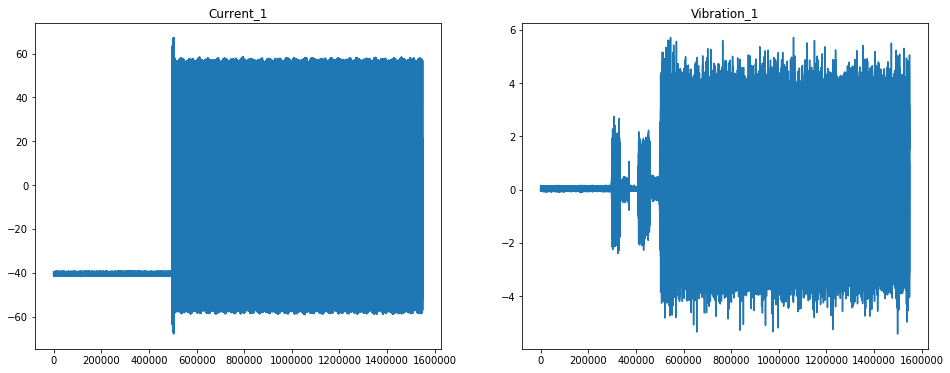

In [113]:
# 查看Current_1，Vibration_1
plot_sensor_byid(sensor_03_1, 0, 2500)

In [114]:
# plot_sensor_byid(sensor_03_1, 550, 600)

### sensor_03_37

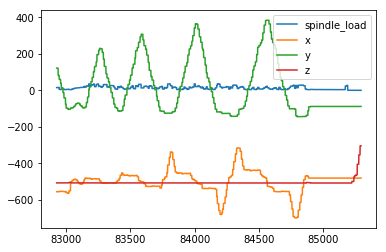

In [115]:
sensor_03_37 = joblib.load('../2.1preprocess_train_data/sensors/03/37.lz4')
plc_03 = joblib.load('../../刀具剩余寿命预测_新数据/2.1preprocess_train_data/train_plc/train_03_plc.lz4')
plc_03_37 = plc_03[plc_03['csv_no']==37]
plc_03_37[['spindle_load','x','y','z']].plot()

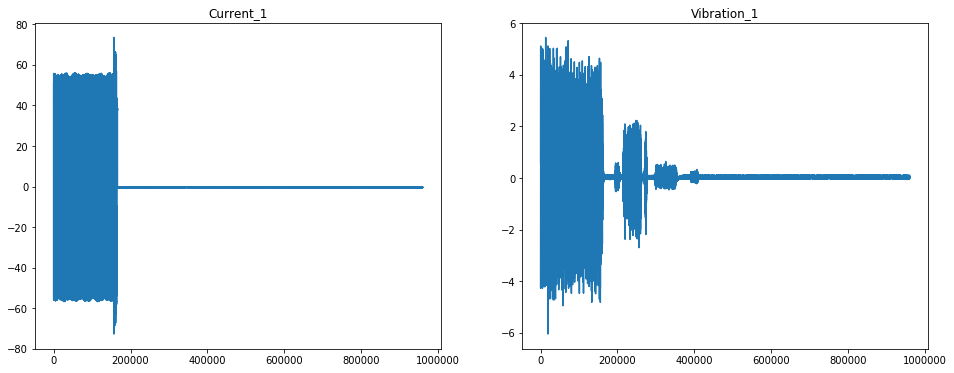

In [116]:
plot_sensor_byid(sensor_03_37, 0, 2500)

### sensor_03_*

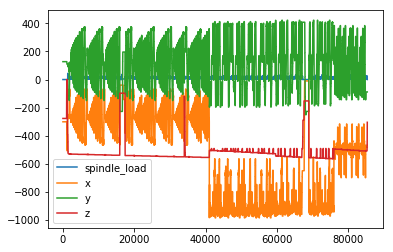

In [130]:
plc_03.loc[plc_03['csv_no']<=37, ['spindle_load','x','y','z']].plot()

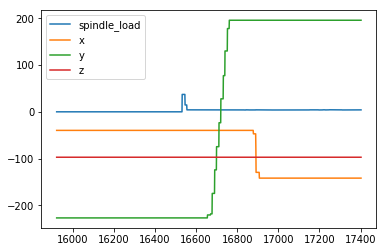

In [154]:
plc_03.loc[plc_03['csv_no']==8, ['spindle_load','x','y','z']].plot()

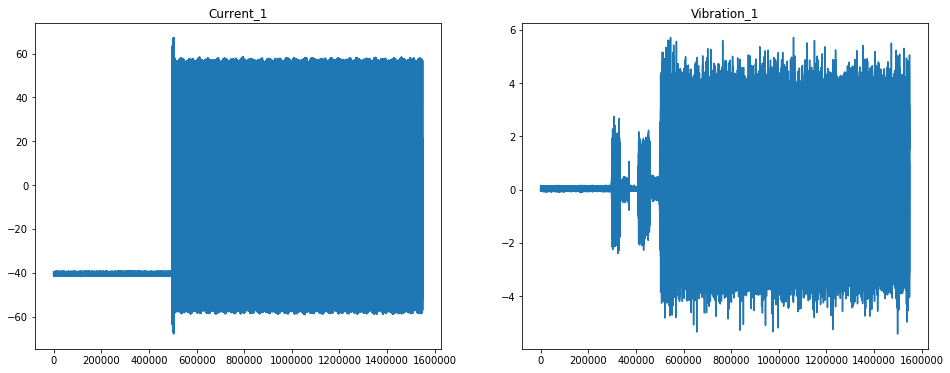

In [151]:
sensor_03_1 = joblib.load('../2.1preprocess_train_data/sensors/03/1.lz4')
plot_sensor_byid(sensor_03_1, 0, 2500)

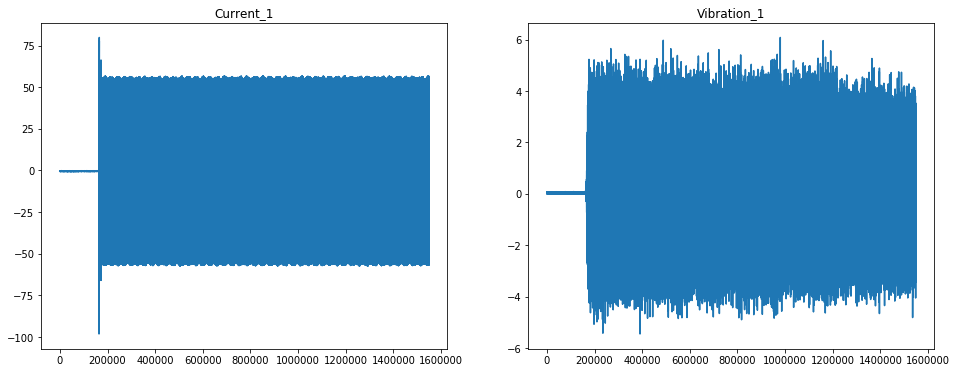

In [153]:
sensor_03_8 = joblib.load('../2.1preprocess_train_data/sensors/03/8.lz4')
plot_sensor_byid(sensor_03_8, 0, 2500)

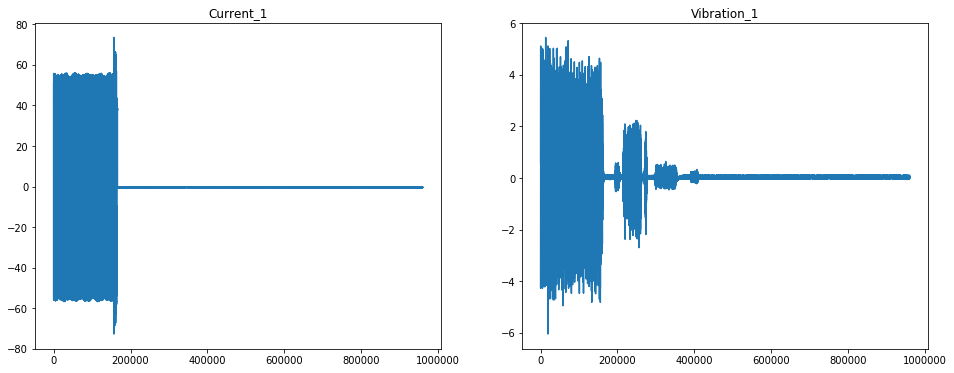

In [155]:
sensor_03_37 = joblib.load('../2.1preprocess_train_data/sensors/03/37.lz4')
plot_sensor_byid(sensor_03_37, 0, 2500)